In [1]:
import easygraph as eg
import csv
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import  pyplot
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score
import random
        
def make_graph(filepath:str):
    G=eg.Graph()
    nodes=[]
    nodes_attr=[]
    edges=[]
    edges_attr=[]
    f=open(filepath,'r')
    next(f)
    csv_reader=csv.reader(f)
    for row in csv_reader:
        i=str(row[0])
        i_affifiation=str(row[1])
        i_country=str(row[2])
        j=str(row[3])
        j_affifiation=str(row[4])
        j_country=str(row[5])
        year=int(row[6])
        area=str(row[7])

        nodes.append(i)
        temp1={}
        temp1['affiliation']=i_affifiation
        temp1['country']=i_country
        nodes_attr.append(temp1)

        nodes.append(j)
        temp2={}
        temp2['affiliation']=j_affifiation
        temp2['country']=j_country
        nodes_attr.append(temp2)

        edges.append((i,j))
        temp3={}
        temp3['year']=year
        temp3['area']=area
        edges_attr.append(temp3)

    G.add_nodes(nodes,nodes_attr)
    G.add_edges(edges,edges_attr)
    return G


In [2]:
# author
G1=make_graph('faculty-coauthors.csv')

In [3]:
SHS=sorted(eg.constraint(G1).items(), key=lambda d: d[1])

In [4]:
con=eg.constraint(G1)
con=sorted(con.items(), key=lambda d: d[1])


SHS1=[]
nonSHS1=[]

kk=int(len(G1)*0.05)
k=0
for i in con:
    if k<kk:
        SHS1.append(i[0])
        k+=1
    else:
        break
        
random.seed(0)
while len(nonSHS1)<kk:
    t=random.sample(con, 1)
    if t[0][0] not in SHS1 and t[0][0] not in nonSHS1:
        nonSHS1.append(t[0][0])
        

In [5]:
# A. Suruliandi	Manonmaniam Sundaranar University	tcss	2	0.58333	2021
f1=open("generated-author-info.csv",'r')
f2=open("country-info2.csv","r")
next(f1)
next(f2)
csv_reader1=csv.reader(f1)
csv_reader2=csv.reader(f2)
List={}
country_list={}
for row in csv_reader2:
    country_list[row[0]]=row[2]
for row in csv_reader1:
    if row[0] in SHS1 or row[0] in nonSHS1:
        if row[0] not in List:
            List[row[0]]={}
            List[row[0]]['country']=country_list[row[1]]
            List[row[0]]['university']=row[1]
            List[row[0]]['journal']=[]
            List[row[0]]['journal'].append(row[2])
            List[row[0]]['paper']=float(row[3])
            List[row[0]]['count']=[]
            List[row[0]]['count'].append(float(row[4]))
            List[row[0]]['year']=[]
            List[row[0]]['year'].append(int(row[5]))
            if row[0] in SHS1:
                List[row[0]]['label']=1
            else:
                List[row[0]]['label']=0
        else:
            if row[2] not in List[row[0]]['journal']:
                List[row[0]]['journal'].append(row[2])
            List[row[0]]['paper']+=float(row[3])
            List[row[0]]['count'].append(float(row[4]))
            List[row[0]]['year'].append(int(row[5]))


In [6]:
data={
    'country':[],
    'university':[],
    'journal':[],
    'paper':[],
    'count':[],
    'year':[],
    'label':[]
}
for i in List:
    data['country'].append(List[i]['country'])
    data['university'].append(List[i]['university'])
    data['journal'].append(len(List[i]['journal']))
    data['paper'].append(List[i]['paper'])
    data['count'].append(np.mean(List[i]['count']))
    data['year'].append(len(List[i]['year'])*2021-sum(List[i]['year']))
    data['label'].append(List[i]['label'])

In [7]:
label_encoder = LabelEncoder()
data['country'] = label_encoder.fit_transform(data['country'])
data['university'] = label_encoder.fit_transform(data['university'])
data=pd.DataFrame(data)
data = pd.get_dummies(data)
data_x = data.drop('label',axis = 1)
data_y = data['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_x,data_y,test_size=0.3,random_state=0)

Best parameters set found on development set:

{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 50, 'num_class': 2, 'objective': 'multi:softprob', 'subsample': 0.8, 'use_label_encoder': 'False'}

Grid scores on development set:

0.891 (+/-0.061) for {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 10, 'num_class': 2, 'objective': 'multi:softprob', 'subsample': 0.8, 'use_label_encoder': 'False'}
0.891 (+/-0.064) for {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 50, 'num_class': 2, 'objective': 'multi:softprob', 'subsample': 0.8, 'use_label_encoder': 'False'}
0.891 (+/-0.064) for {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0, 'l

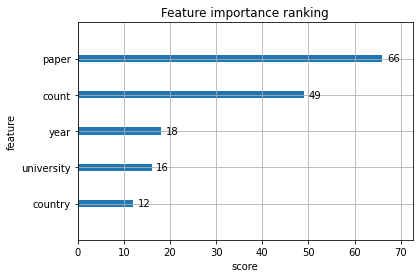

In [8]:
warnings.filterwarnings("ignore")
parameters_grid_XGB = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [10, 50, 100], 
    'max_depth': [4,6,8], 
    'min_child_weight':[1],
    'subsample': [0.8],
    'colsample_bytree':[0.8], 
    'gamma':[0,2,4],
    
    'booster': ['gbtree'],
    'num_class':[2],
    'eval_metric':["auc"],
    'objective':['multi:softprob'],
    #'seed':[0],
    'use_label_encoder':['False']
}
XGB = XGBClassifier()
grid = GridSearchCV(XGB, parameters_grid_XGB, cv=5, scoring='precision')
grid.fit(Xtrain, Ytrain)

print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
bclf = grid.best_estimator_
bclf.fit(Xtrain, Ytrain)
y_true = Ytest
y_pred = bclf.predict(Xtest)
y_pred_pro = bclf.predict_proba(Xtest)
y_scores = pd.DataFrame(y_pred_pro, columns=bclf.classes_.tolist())[1].values
print(classification_report(y_true, y_pred))
auc_value = roc_auc_score(y_true, y_scores)
print("auc_value:")
print(auc_value)

plot_importance(bclf,title='Feature importance ranking', xlabel='score', ylabel='feature')
pyplot.show()


In [9]:
def make_graph_country(filepath:str):
    G=eg.Graph()
    nodes=[]
    nodes_attr=[]
    edges=[]
    edges_attr=[]
    f=open(filepath,'r')
    next(f)
    csv_reader=csv.reader(f)
    for row in csv_reader:
        i=str(row[2])
        j=str(row[5])
        if i not in nodes:
            nodes.append(i)
        if j not in nodes:
            nodes.append(j)

        if (i,j) in edges:
            index=edges.index((i,j))
            edges_attr[index]['weight']+=1
        else:
            edges.append((i,j))
            temp3={}
            temp3['weight']=1
            edges_attr.append(temp3)

    G.add_nodes(nodes)
    G.add_edges(edges,edges_attr)
    return G


In [10]:
# country
G2=make_graph_country('faculty-coauthors.csv')

In [13]:
con=eg.constraint(G2)
con=sorted(con.items(), key=lambda d: d[1])


SHS2=[]
nonSHS2=[]

kk=int(len(G2)*0.1)
k=0
for i in con:
    if k<kk:
        SHS2.append(i[0])
        k+=1
    else:
        break
        
random.seed(0)
while len(nonSHS2)<kk:
    t=random.sample(con, 1)
    if t[0][0] not in SHS2 and t[0][0] not in nonSHS2:
        nonSHS2.append(t[0][0])
        

In [14]:
SHS2

['us', 'cn', 'uk', 'nl', 'au', 'de']

In [17]:
print(sorted(G2.degree().items(), key=lambda d: d[1],reverse=True))

[('us', 6385), ('cn', 4156), ('nl', 820), ('in', 729), ('uk', 721), ('au', 510), ('de', 449), ('it', 317), ('jp', 264), ('sg', 250), ('tw', 249), ('es', 246), ('fi', 209), ('be', 200), ('ca', 197), ('kr', 193), ('fr', 172), ('br', 160), ('ir', 136), ('il', 128), ('si', 117), ('hk', 112), ('hu', 102), ('ch', 99), ('sa', 76), ('se', 70), ('ie', 65), ('pt', 61), ('at', 53), ('pk', 48), ('mx', 47), ('th', 44), ('py', 40), ('eg', 25), ('dk', 22), ('ae', 21), ('pl', 19), ('ru', 17), ('cl', 17), ('qa', 16), ('gr', 16), ('tr', 16), ('no', 16), ('jo', 15), ('om', 15), ('co', 13), ('lb', 12), ('tn', 11), ('by', 8), ('cy', 7), ('ua', 6), ('vn', 4), ('bd', 4), ('hr', 4), ('ar', 3), ('ma', 3), ('bg', 3), ('sn', 3), ('et', 2), ('za', 1)]


In [18]:
print(sorted(eg.constraint(G2).items(), key=lambda d: d[1]))

[('us', 0.1420960601431195), ('cn', 0.15499553165252775), ('uk', 0.16096495294577745), ('nl', 0.16554854162313873), ('au', 0.1702654662901221), ('de', 0.18105502078697017), ('fr', 0.19502649583386833), ('in', 0.1959702460973969), ('ca', 0.20204033124800388), ('es', 0.2103185646956769), ('fi', 0.22946291244673983), ('pt', 0.23650261243277831), ('it', 0.23727161033114222), ('ch', 0.24523651291964804), ('sa', 0.24820240956781336), ('sg', 0.24967966392471663), ('se', 0.25951606728909615), ('be', 0.2661165405586546), ('ru', 0.26757468757502456), ('qa', 0.2701746809257247), ('jp', 0.2709208110211652), ('py', 0.27474579609669647), ('hk', 0.2826420774656595), ('ie', 0.29350787938853107), ('no', 0.31343819146189317), ('pk', 0.3281199368236662), ('hu', 0.36425778931141084), ('pl', 0.37905828513576484), ('br', 0.3916919151645878), ('at', 0.40062685652130803), ('tw', 0.4085275194714575), ('il', 0.46926891099577084), ('th', 0.48620501116694065), ('si', 0.48887764877462897), ('mx', 0.501483303697295

In [32]:
country={
    'us':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'cn':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'nl':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'in':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'uk':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'au':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'de':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    }
}
country_shs={
    'us':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'cn':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'nl':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'in':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'uk':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'au':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    },
    'de':{
        'paper':0,
        'count':0,
        'year':0,
        'author':[]
    }
}

In [39]:
# paper count year
# A. Suruliandi	Manonmaniam Sundaranar University	tcss	2	0.58333	2021

f=open('generated-author-info.csv','r')
next(f)
csv_reader=csv.reader(f)
for row in csv_reader:
    if country_list[row[1]] in country.keys():
        country[country_list[row[1]]]['paper']+=float(row[3])
        country[country_list[row[1]]]['count']+=float(row[4])
        country[country_list[row[1]]]['year']+=2021-int(row[5])
        if row[0] not in country[country_list[row[1]]]['author']:
            country[country_list[row[1]]]['author'].append(row[0])
    if row[0] in SHS1 and country_list[row[1]] in country_shs.keys():
        country_shs[country_list[row[1]]]['paper']+=float(row[3])
        country_shs[country_list[row[1]]]['count']+=float(row[4])
        country_shs[country_list[row[1]]]['year']+=2021-int(row[5])
        if row[0] not in country_shs[country_list[row[1]]]['author']:
            country_shs[country_list[row[1]]]['author'].append(row[0])

In [45]:
country_ave={
    'us':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'cn':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'nl':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'in':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'uk':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'au':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'de':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    }
}

country_shs_ave={
    'us':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'cn':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'nl':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'in':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'uk':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'au':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    },
    'de':{
        'paper':0,
        'count':0,
        'year':0,
        'num':0
    }
}

In [46]:
for i in country:
    country_ave[i]['paper']=country[i]['paper']/len(country[i]['author'])
    country_ave[i]['count']=country[i]['count']/len(country[i]['author'])
    country_ave[i]['year']=country[i]['year']/len(country[i]['author'])
    country_ave[i]['num']=len(country[i]['author'])
for i in country_shs:
    country_shs_ave[i]['paper']=country_shs[i]['paper']/len(country_shs[i]['author'])
    country_shs_ave[i]['count']=country_shs[i]['count']/len(country_shs[i]['author'])
    country_shs_ave[i]['year']=country_shs[i]['year']/len(country_shs[i]['author'])
    country_shs_ave[i]['num']=len(country_shs[i]['author'])

In [47]:
print(country_ave)

{'us': {'paper': 2.91674127126231, 'count': 1.0515458137869442, 'year': 16.229185317815578, 'num': 1117}, 'cn': {'paper': 3.0253411306042883, 'count': 0.667184530214424, 'year': 4.393762183235867, 'num': 513}, 'nl': {'paper': 3.552, 'count': 1.3003207999999982, 'year': 27.632, 'num': 125}, 'in': {'paper': 2.5076923076923077, 'count': 0.7744846153846158, 'year': 3.8461538461538463, 'num': 130}, 'uk': {'paper': 2.677685950413223, 'count': 0.8103633057851242, 'year': 12.710743801652892, 'num': 121}, 'au': {'paper': 3.3333333333333335, 'count': 0.685931818181818, 'year': 10.303030303030303, 'num': 66}, 'de': {'paper': 2.55, 'count': 0.9762484999999999, 'year': 11.6, 'num': 80}}


In [48]:
print(country_shs_ave)

{'us': {'paper': 11.581395348837209, 'count': 3.914314372093019, 'year': 64.55813953488372, 'num': 43}, 'cn': {'paper': 9.904761904761905, 'count': 2.147105904761904, 'year': 7.333333333333333, 'num': 42}, 'nl': {'paper': 14.0, 'count': 4.958917499999997, 'year': 88.75, 'num': 8}, 'in': {'paper': 8.5, 'count': 1.8250000000000004, 'year': 7.5, 'num': 4}, 'uk': {'paper': 10.285714285714286, 'count': 3.5411571428571422, 'year': 49.142857142857146, 'num': 7}, 'au': {'paper': 12.0, 'count': 2.604871428571428, 'year': 36.857142857142854, 'num': 7}, 'de': {'paper': 12.0, 'count': 4.8333200000000005, 'year': 94.0, 'num': 1}}
